In [1]:
%cd /Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas

/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas


/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Registro y evaluación de experimentos con MLflow  
## Modelo SEIR para enfermedad de Chagas en Valledupar (Cesar)

En este cuaderno se documenta el registro y análisis de los experimentos realizados con el modelo SEIR calibrado para los casos de enfermedad de Chagas en Valledupar (Cesar), durante 2024.

Los objetivos específicos son:

1. Verificar que los experimentos de calibración del modelo SEIR queden registrados en MLflow.
2. Cargar los resultados del ajuste (series observadas y simuladas) a partir de los artefactos del pipeline.
3. Calcular métricas de rendimiento del modelo:
   - Métricas de regresión: RMSE, MAE, R².
   - Métricas de clasificación binaria a partir de semanas de alta incidencia: exactitud, precisión, recall, F1 y AUC-ROC.
4. Registrar estas métricas y las principales figuras de evaluación como artefactos en MLflow.
5. Realizar una interpretación final de los resultados del modelo desde la perspectiva epidemiológica.

In [3]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve,
    auc,
)

import mlflow
from mlflow.tracking import MlflowClient

plt.style.use("seaborn-v0_8")


# Registro y evaluación de experimentos con MLflow

En este cuaderno se documenta el registro y la evaluación del modelo SEIR
calibrado para la enfermedad de Chagas en Valledupar (Cesar).

Los objetivos son:

1. Cargar los resultados del ajuste semanal (`reports/seir_valledupar.csv`).
2. Identificar las columnas de casos observados y casos simulados.
3. Calcular métricas de desempeño en regresión (MAE, MSE, RMSE, R²).
4. Definir un criterio binario de “semana de alta transmisión” y evaluar el
   modelo como clasificador (exactitud, precisión, recall, F1, ROC–AUC).
5. Generar gráficos de evaluación:  
   - Serie observada vs simulada.  
   - Matriz de confusión.  
   - Curva ROC.  
   - Gráfico de residuos.
6. Registrar los resultados y artefactos en MLflow como experimento.

In [8]:
import pathlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)

# Intentar importar mlflow; si no está instalado, el notebook sigue funcionando
try:
    import mlflow

    MLFLOW_AVAILABLE = True
except ImportError:
    mlflow = None  # type: ignore
    MLFLOW_AVAILABLE = False

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.dpi"] = 120

BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas')

In [9]:
# Ruta al archivo de resultados del ajuste
ajuste_path = BASE_DIR / "reports" / "seir_valledupar.csv"

if not ajuste_path.exists():
    raise FileNotFoundError(f"No se encontró el archivo {ajuste_path}")

ajuste_df = pd.read_csv(ajuste_path)

print("Columnas disponibles en seir_valledupar.csv:")
print(ajuste_df.columns.tolist())

ajuste_df.head()

Columnas disponibles en seir_valledupar.csv:
['Fecha', 'casos_reales', 'casos_modelo_opt']


,Fecha,casos_reales,casos_modelo_opt
0,2024-01-01,2.0,0.773762
1,2024-01-22,1.0,5.919641
2,2024-02-12,6.0,15.824527
3,2024-02-26,1.0,25.105846
4,2024-03-04,1.0,30.990684


In [10]:
# Detectar columna de fecha
posibles_fecha = ["Fecha", "fecha", "date"]
fecha_col = next((c for c in posibles_fecha if c in ajuste_df.columns), None)

if fecha_col is None:
    raise ValueError(
        f"No se encontró columna de fecha en {ajuste_df.columns.tolist()}"
    )

# Detectar columna de casos observados
posibles_obs = ["casos_reales", "casos_obs", "casos", "y_true"]
obs_col = next((c for c in posibles_obs if c in ajuste_df.columns), None)

if obs_col is None:
    raise ValueError(
        f"No se encontró columna de casos observados. Columnas: {ajuste_df.columns.tolist()}"
    )

# Detectar columna del modelo (simulada)
# Regla: cualquier columna numérica distinta de la observada
numeric_cols = ajuste_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

model_candidates = [c for c in numeric_cols if c != obs_col]

if not model_candidates:
    raise ValueError(
        f"No se encontró columna candidata para el modelo. Columnas numéricas: {numeric_cols}"
    )
elif len(model_candidates) == 1:
    model_col = model_candidates[0]
else:
    # Si hay varias, preferimos alguna que contenga 'modelo' o 'sim'
    preferidas = [
        c
        for c in model_candidates
        if ("modelo" in c.lower()) or ("sim" in c.lower()) or ("I_" in c)
    ]
    if len(preferidas) == 1:
        model_col = preferidas[0]
    else:
        # Si sigue habiendo ambigüedad, tomamos la última numérica distinta de la observada
        model_col = model_candidates[-1]

print(f"Columna de fecha       : {fecha_col}")
print(f"Columna casos observados: {obs_col}")
print(f"Columna modelo/simulado : {model_col}")

# Asegurar tipos numéricos
ajuste_df[obs_col] = ajuste_df[obs_col].astype(float)
ajuste_df[model_col] = ajuste_df[model_col].astype(float)

# Ordenar por fecha por claridad
ajuste_df[fecha_col] = pd.to_datetime(ajuste_df[fecha_col])
ajuste_df = ajuste_df.sort_values(fecha_col).reset_index(drop=True)

ajuste_df[[fecha_col, obs_col, model_col]].head()

Columna de fecha       : Fecha
Columna casos observados: casos_reales
Columna modelo/simulado : casos_modelo_opt


,Fecha,casos_reales,casos_modelo_opt
0,2024-01-01,2.0,0.773762
1,2024-01-22,1.0,5.919641
2,2024-02-12,6.0,15.824527
3,2024-02-26,1.0,25.105846
4,2024-03-04,1.0,30.990684


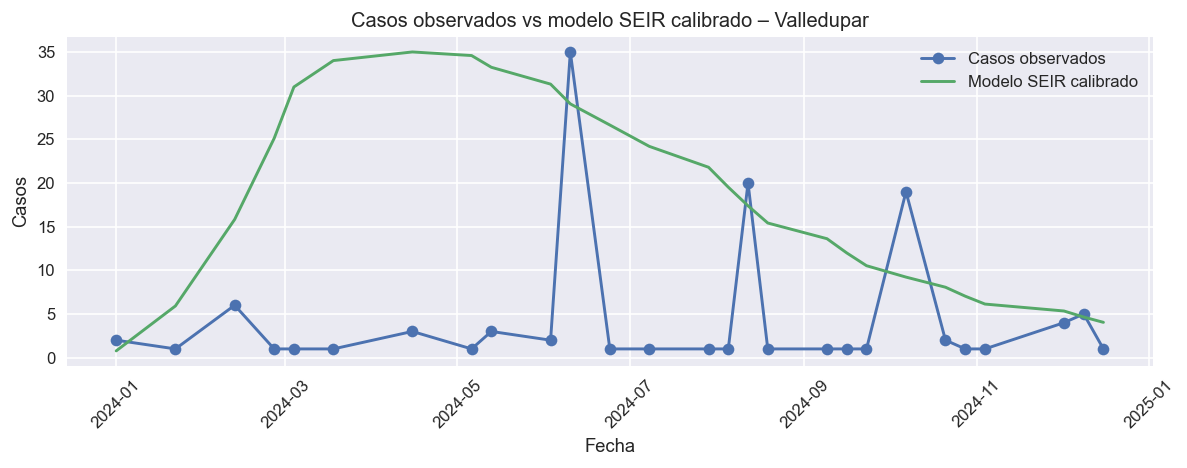

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(ajuste_df[fecha_col], ajuste_df[obs_col], marker="o", label="Casos observados")
plt.plot(
    ajuste_df[fecha_col],
    ajuste_df[model_col],
    marker="x",
    label="Modelo SEIR calibrado",
)
plt.xlabel("Fecha")
plt.ylabel("Casos")
plt.title("Casos observados vs modelo SEIR calibrado – Valledupar")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
y_true = ajuste_df[obs_col].values
y_pred = ajuste_df[model_col].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("Métricas de regresión:")
print(f"  MAE  : {mae:.4f}")
print(f"  MSE  : {mse:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  R²   : {r2:.4f}")

Métricas de regresión:
  MAE  : 14.9715
  MSE  : 348.7569
  RMSE : 18.6750
  R²   : -4.8779


In [13]:
# Umbral para definir "alta transmisión"
# Usamos el cuantil 0.75 de los casos observados
umbral = np.quantile(y_true, 0.75)

print(f"Umbral de alta transmisión (cuantil 0.75): {umbral:.2f}")

y_true_cls = (y_true >= umbral).astype(int)
y_pred_cls = (y_pred >= umbral).astype(int)

acc = accuracy_score(y_true_cls, y_pred_cls)
prec = precision_score(y_true_cls, y_pred_cls, zero_division=0)
rec = recall_score(y_true_cls, y_pred_cls, zero_division=0)
f1 = f1_score(y_true_cls, y_pred_cls, zero_division=0)

# Para ROC–AUC usamos la serie continua y_pred como score
try:
    roc_auc = roc_auc_score(y_true_cls, y_pred)
except ValueError:
    roc_auc = np.nan

print("\nMétricas de clasificación (alta transmisión vs baja):")
print(f"  Exactitud (accuracy) : {acc:.4f}")
print(f"  Precisión (precision): {prec:.4f}")
print(f"  Recall               : {rec:.4f}")
print(f"  F1-score             : {f1:.4f}")
print(f"  ROC–AUC              : {roc_auc:.4f}")

Umbral de alta transmisión (cuantil 0.75): 3.00

Métricas de clasificación (alta transmisión vs baja):
  Exactitud (accuracy) : 0.3333
  Precisión (precision): 0.3077
  Recall               : 1.0000
  F1-score             : 0.4706
  ROC–AUC              : 0.5329


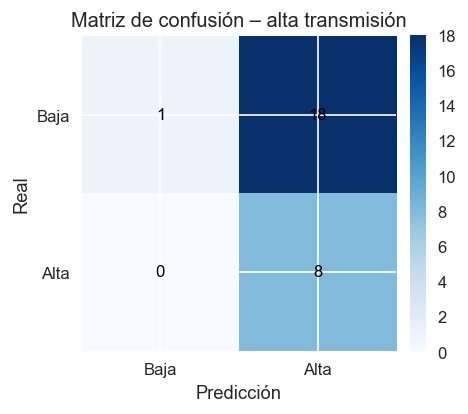

Matriz de confusión guardada en: /Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas/reports/cm_seir_valledupar.png


In [14]:
cm = confusion_matrix(y_true_cls, y_pred_cls)

fig_cm, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, cmap="Blues")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Baja", "Alta"])
ax.set_yticklabels(["Baja", "Alta"])

ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
ax.set_title("Matriz de confusión – alta transmisión")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

fig_cm.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()

cm_path = BASE_DIR / "reports" / "cm_seir_valledupar.png"
fig_cm.savefig(cm_path, bbox_inches="tight")
plt.show()

print(f"Matriz de confusión guardada en: {cm_path}")

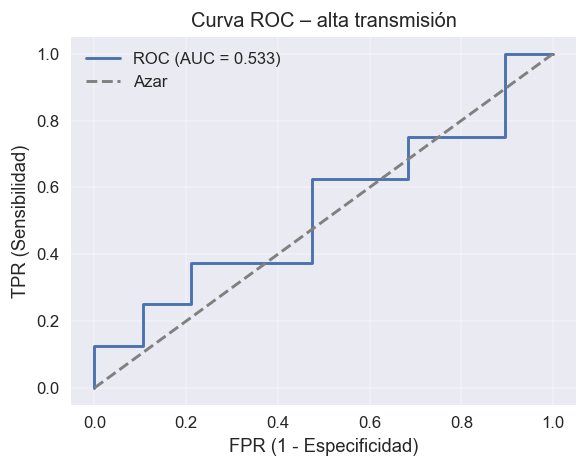

Curva ROC guardada en: /Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas/reports/roc_seir_valledupar.png


In [15]:
fpr, tpr, thresholds = roc_curve(y_true_cls, y_pred)

fig_roc, ax = plt.subplots(figsize=(5, 4))
ax.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Azar")
ax.set_xlabel("FPR (1 - Especificidad)")
ax.set_ylabel("TPR (Sensibilidad)")
ax.set_title("Curva ROC – alta transmisión")
ax.legend()
ax.grid(alpha=0.3)

roc_path = BASE_DIR / "reports" / "roc_seir_valledupar.png"
fig_roc.savefig(roc_path, bbox_inches="tight")
plt.tight_layout()
plt.show()

print(f"Curva ROC guardada en: {roc_path}")

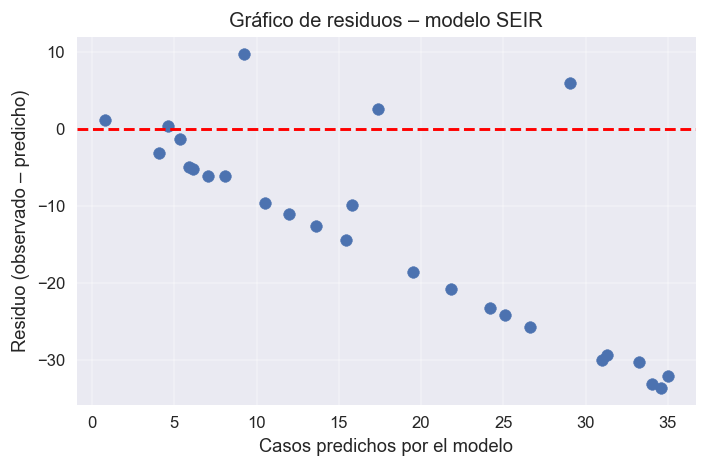

Gráfico de residuos guardado en: /Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas/reports/residuos_seir_valledupar.png


In [16]:
residuos = y_true - y_pred

fig_res, ax = plt.subplots(figsize=(6, 4))
ax.scatter(y_pred, residuos)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("Casos predichos por el modelo")
ax.set_ylabel("Residuo (observado – predicho)")
ax.set_title("Gráfico de residuos – modelo SEIR")
ax.grid(alpha=0.3)

res_path = BASE_DIR / "reports" / "residuos_seir_valledupar.png"
fig_res.savefig(res_path, bbox_inches="tight")
plt.tight_layout()
plt.show()

print(f"Gráfico de residuos guardado en: {res_path}")


In [17]:
if not MLFLOW_AVAILABLE:
    print("MLflow no está instalado en este entorno. Se omite el registro.")
else:
    mlflow.set_experiment("chagas_seir_valledupar")

    with mlflow.start_run(run_name="evaluacion_nb05") as run:
        # Parámetros
        mlflow.log_param("umbral_alta_transmision", float(umbral))
        mlflow.log_param("column_obs", obs_col)
        mlflow.log_param("column_model", model_col)
        mlflow.log_param("n_sem", len(y_true))

        # Métricas de regresión
        mlflow.log_metric("mae", float(mae))
        mlflow.log_metric("mse", float(mse))
        mlflow.log_metric("rmse", float(rmse))
        mlflow.log_metric("r2", float(r2))

        # Métricas de clasificación
        mlflow.log_metric("accuracy", float(acc))
        mlflow.log_metric("precision", float(prec))
        mlflow.log_metric("recall", float(rec))
        mlflow.log_metric("f1", float(f1))
        if not np.isnan(roc_auc):
            mlflow.log_metric("roc_auc", float(roc_auc))

        # Artefactos
        mlflow.log_artifact(str(ajuste_path), artifact_path="data")
        mlflow.log_artifact(str(cm_path), artifact_path="figures")
        mlflow.log_artifact(str(roc_path), artifact_path="figures")
        mlflow.log_artifact(str(res_path), artifact_path="figures")

    print("Experimento registrado en MLflow.")

Experimento registrado en MLflow.
